CALL option price: 10.4568 ± 0.0289 (95% CI)
PUT option price: 5.5779 ± 0.0170 (95% CI)


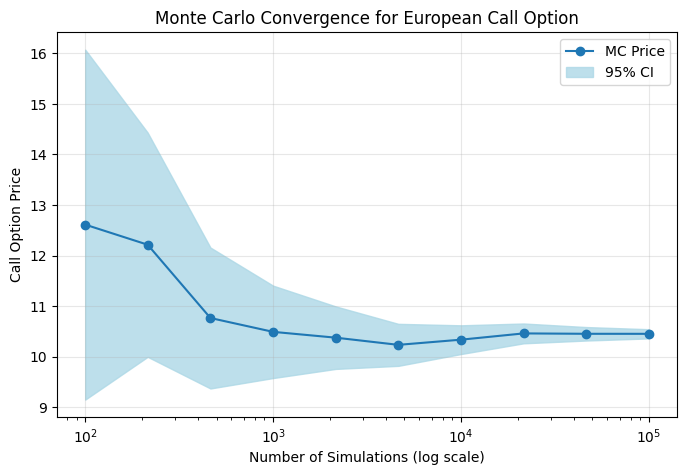

In [26]:
# BlackScholes_MonteCarlo.ipynb

# -------------------------------
# 1. Setup & Imports
# -------------------------------
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 2. Monte Carlo Pricer Function
# -------------------------------
def monte_carlo_pricer(
    S0, K, T, r, sigma, option_type="call",
    n_sim=1000000, antithetic=True, seed=None
):
    """
    Monte Carlo pricer for European options under Black-Scholes.
    Returns: price, standard error
    """
    if seed is not None:
        np.random.seed(seed)

    # half samples if antithetic
    n_paths = n_sim // 2 if antithetic else n_sim
    Z = np.random.randn(n_paths)

    drift = (r - 0.5 * sigma**2) * T
    diffusion = sigma * np.sqrt(T)

    ST1 = S0 * np.exp(drift + diffusion * Z)

    if antithetic:
        ST2 = S0 * np.exp(drift - diffusion * Z)
        ST = np.concatenate([ST1, ST2])
    else:
        ST = ST1

    if option_type.lower() == "call":
        payoff = np.maximum(ST - K, 0.0)
    else:
        payoff = np.maximum(K - ST, 0.0)

    discounted = np.exp(-r * T) * payoff
    price = np.mean(discounted)
    se = np.std(discounted, ddof=1) / np.sqrt(len(discounted))
    return price, se

# -------------------------------
# 3. Example Pricing
# -------------------------------
S0, K, T, r, sigma = 100, 100, 1, 0.05, 0.2

for opt in ["call", "put"]:
    price, se = monte_carlo_pricer(S0, K, T, r, sigma, opt, n_sim=1000000, antithetic=True, seed=42)
    print(f"{opt.upper()} option price: {price:.4f} ± {1.96*se:.4f} (95% CI)")

# -------------------------------
# 4. Convergence Experiment
# -------------------------------
sims = np.logspace(2, 5, 10, dtype=int)  # from 1e2 to 1e5
call_estimates, call_se = [], []

for n in sims:
    price, se = monte_carlo_pricer(S0, K, T, r, sigma, "call", n_sim=n, antithetic=True, seed=123)
    call_estimates.append(price)
    call_se.append(se)

# -------------------------------
# 5. Plot Convergence
# -------------------------------
plt.figure(figsize=(8,5))
plt.plot(sims, call_estimates, marker="o", label="MC Price")
plt.fill_between(
    sims,
    np.array(call_estimates) - 1.96*np.array(call_se),
    np.array(call_estimates) + 1.96*np.array(call_se),
    color="lightblue", alpha=0.80, label="95% CI"
)
plt.xscale("log")
plt.xlabel("Number of Simulations (log scale)")
plt.ylabel("Call Option Price")
plt.title("Monte Carlo Convergence for European Call Option")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
